In [ ]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

In [20]:
# Ingresar imágenes de dígitos de una resolucion de 20x20 pixeles
input_layer_size  = 400

# de 1 a 10 (tomar en cuenta que se asigna "0" a la etiqueta 10)
# número de etiquetas de clase diferentes que se utilizarán para el reconocimiento de dígitos
num_labels = 10

#  datos de entrenamiento almacenados en los arreglos X, y
data = loadmat(os.path.join('emnist-mnist.mat'))
# Aquí se asignan los arreglos de imágenes y etiquetas a las variables X y y, respectivamente.
# X contendrá las imágenes de los dígitos, y y contendrá las etiquetas correspondientes a cada imagen.
X, y = data['dataset'][0][0]['train'][0][0]['images'], data['dataset'][0][0]['train'][0][0]['labels'].ravel()
# establecer el dígito cero en 0, en lugar del 10 asignado a este conjunto de datos
# Esto se hace debido a que el conjunto de datos se utilizó en MATLAB donde no hay índice 0
y[y == 10] = 0

m = y.size

In [24]:
# imprimimos X y y (imagenes y etiquetas)
print(X)
print(y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[4 1 4 ... 1 5 0]


In [22]:
def displayData(X, example_width=None, figsize=(10, 10)):
    # con esta funciaon mostraremos los datos almacenados en X
    # Calculamos filas y columnas
    if X.ndim == 2: #verifica si X tiene 2 dimensiones
        m, n = X.shape #m numero de filas, n numero de columnas  de X
    elif X.ndim == 1: # si X tiene 1 dimension, n obtendra el mismo tamaño y m se ejecutara con 1
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.') # si no tiene 1 o 2 dimensiones devuelve un error

    example_width = example_width or int(np.round(np.sqrt(n))) #calculamos el ancho de cada ejemplo de imagen
    example_height = n / example_width # altura, lo mismo que con ancho,

    # Calcula el numero de elementos a mostrar
    # calculamos el número de filas y columnas en la cuadrícula de imágenes en función del número de ejemplos m.
    # redondeamos hacia abajo el número de filas utilizando np.floor y se redondea hacia arriba el número de columnas utilizando np.ceil
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    # Esta línea de código crea una figura de matplotlib con una cuadrícula de ejes (ax_array) que corresponde a la cuadrícula de imágenes
    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    # Esta línea de código ajusta el espacio entre los ejes en la figura.
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    # Si m es igual a 1, se envuelve ax_array en una lista para que se pueda iterar correctamente en el siguiente bucle
    # Si m es mayor que 1, se aplana ax_array para obtener una lista plana de ejes
    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    #itera sobre los ejes en ax_array y muestra cada ejemplo de imagen en un eje. X[i]
    
    for i, ax in enumerate(ax_array):
        # La imagen se muestra en escala de grises utilizando el mapa de colores 'Greys'
        # y se establece el rango de los ejes x e y en [0, 1] utilizando extent=[0, 1, 0, 1]
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        # Finalmente, se desactivan los ejes utilizando ax.axis('off').
        ax.axis('off')

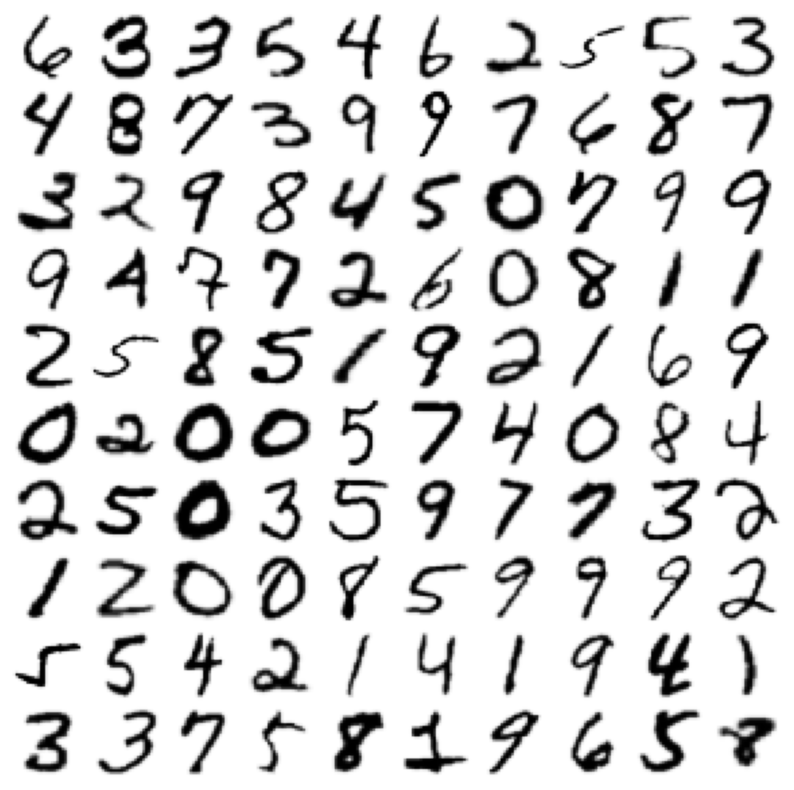

In [23]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [ ]:
# valores de prueba para los parámetros theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# valores de prueba para las entradas
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)
#matriz resultante
print(X_t)
# valores de testeo para las etiquetas
y_t = np.array([1, 0, 1, 0, 1])

# valores de testeo para el parametro de regularizacion
lambda_t = 3

[[1.  0.1 0.6 1.1]
 [1.  0.2 0.7 1.2]
 [1.  0.3 0.8 1.3]
 [1.  0.4 0.9 1.4]
 [1.  0.5 1.  1.5]]


In [ ]:
def sigmoid(z):
    """
    Calcula la sigmoide de z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [ ]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada y 
    el gradiente del costo w.r.t. a los parámetros.
    theta: Parametro theta de la regresion logistica. Vector de la forma(shape) (n, ). n es el numero de caracteristicas 
        incluida la intercepcion
        
    X: Dataset con la forma(shape) (m x n). m es el numero de ejemplos, y n es el numero de 
        caracteristicas (incluida la intercepcion).
    
    y: El conjunto de etiquetas. Un vector con la forma (shape) (m, ). m es el numero de ejemplos
    
    lambda_: Parametro de regularización. 

    J : El valor calculado para la funcion de costo regularizada. 
    
    grad: Un vector de la forma (shape) (n, ) que es el gradiente de la 
        función de costo con respecto a theta, en los valores actuales de theta..
    """
    # Inicializa algunos valores utiles
    m = y.size
    
    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)
    
    J = 0
    grad = np.zeros(theta.shape)
    
    h = sigmoid(X.dot(theta.T))
    
    temp = theta
    temp[0] = 0
    
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    
    grad = (1 / m) * (h - y).dot(X) 
    grad = grad + (lambda_ / m) * temp

    return J, grad

In [ ]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Costo         : {:.6f}'.format(J))
print('Costo esperadot: 2.534819')
print('-----------------------')
print('Gradientes:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Gradientes esperados:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Costo         : 2.534819
Costo esperadot: 2.534819
-----------------------
Gradientes:
 [0.146561, -0.548558, 0.724722, 1.398003]
Gradientes esperados:
 [0.146561, -0.548558, 0.724722, 1.398003]


In [25]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Entrena num_labels clasificadores de regresión logística y devoluciones
     cada uno de estos clasificadores en una matriz all_theta, donde el i-ésimo
     fila de all_theta corresponde al clasificador para la etiqueta i.

    X: El conjunto de datos de entrada de forma (m x n). m es el número de
         puntos de datos, y n es el número de características. Tenga en cuenta que nosotros
         no asuma que el término de intersección (o sesgo) está en X, sin embargo
         proporcionamos el código a continuación para agregar el término de sesgo a X.
    
    y: Las etiquetas de datos. Un vector de forma (m, ).
    
    num_labels: Número de etiquetas posibles.
    
    lambda_ : El parámetro de regularización logística.
    
    all_theta : Los parámetros entrenados para la regresión logística para cada clase.
         Esta es una matriz de forma (K x n+1) donde K es el número de clases
         (es decir, `numlabels`) y n es el número de características sin el sesgo.
    """
    # algunas variables utiles
    # Se obtienen las dimensiones de la matriz de características X, donde m representa el número de ejemplos y n representa el número de características
    m, n = X.shape
    
    # iniciamos variable all_theta con ceros con dimensiones 10, y numeros de caracteristicas
    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
 
    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='CG',
                                options=options) 
        #Se guarda el vector de parámetros óptimos en la fila correspondiente
        all_theta[c] = res.x

    return all_theta

In [ ]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

<ipython-input-12-575a438e2fc3>:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
<ipython-input-13-856bf3e5d20b>:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-12-575a438e2fc3>:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
<ipython-input-13-856bf3e5d20b>:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-12-575a438e2fc3>:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
<ipython-input-13-856bf3e5d20b>:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))


In [ ]:
    def predictOneVsAll(all_theta, X):
        """
        Devuelve un vector de predicciones para cada ejemplo en la matriz X.
        Tenga en cuenta que X contiene los ejemplos en filas. 
        all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase. 
        Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1] 
        predice clases 0, 2, 0, 1 para 4 ejemplos).

        all_theta : Los parámetros entrenados para la regresión logística para cada clase.
             Esta es una matriz de forma (K x n+1) donde K es el número de clases
             y n es el número de características sin el sesgo.
        
        X : Puntos de datos para predecir sus etiquetas. Esta es una matriz de forma
             (m x n) donde m es el número de puntos de datos para predecir, y n es el número
             de características sin el término de sesgo. Tenga en cuenta que agregamos el término de sesgo para X en
             esta función.
        
        p : Las predicciones para cada punto de datos en X. Este es un vector de forma (m, ).
        """
        
        m = X.shape[0];
        num_labels = all_theta.shape[0]

        p = np.zeros(m)

        # Agregar unos a la matriz de datos X
        X = np.concatenate([np.ones((m, 1)), X], axis=1)
        p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

        return p

(60000, 784)
Precision del conjuto de entrenamiento: 86.80%
(1, 784)
(1, 785)
[1]


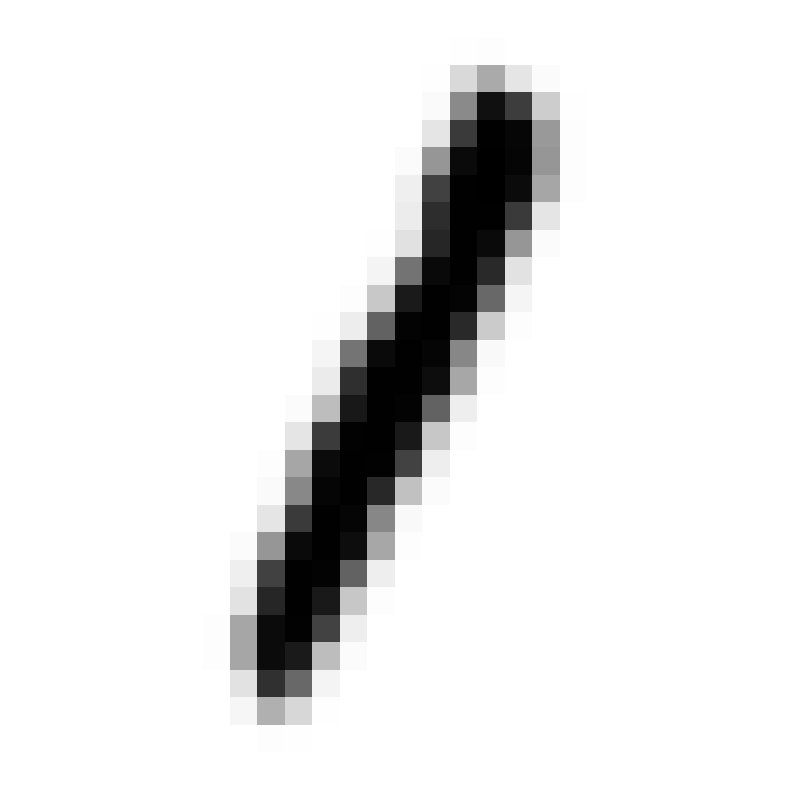

In [ ]:
print(X.shape)
pred = predictOneVsAll(all_theta, X)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))
XPrueba = X[4002:4003, :].copy()
print(XPrueba.shape)
#print(np.ones((1)))
#print(XPrueba)
#p = np.zeros(1)
XPrueba = np.concatenate([np.ones((1, 1)), XPrueba], axis=1)
print(XPrueba.shape)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis = 1)
print(p)

displayData(X[4002:4003, :])